In [98]:
import itertools
import pickle

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score,\
classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification

from tqdm import tqdm
from tqdm import trange

import warnings
warnings.filterwarnings('ignore')

# Create functions

In [99]:
def standardize_text(df):
    df['Translated text'] = df['Translated text'].str.replace(r'[^\w\s]|(https|http)\S+|_x000d\S+', "",
                                                                    regex=True)
    df['Translated text'] = df['Translated text'].dropna()
    return df

In [100]:
def build_features(df):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2),
                            stop_words='english')
    X = tfidf.fit_transform(df['Translated text']).toarray()
    y = df['Relation to nuclear sphere']
    return X, y, tfidf

In [101]:
def train_model(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    return clf

In [102]:
def show_metrics(y_test, y_pred):
    precision = precision_score(y_test, y_pred, pos_label=None, average='macro')
    recall = recall_score(y_test, y_pred, pos_label=None, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    
    f1 = f1_score(y_test, y_pred, pos_label=None, average='macro')
    roc_auc = roc_auc_score(y_test, y_pred)

    return accuracy, precision, recall, f1, roc_auc

In [103]:
def bert_preprocessing(text, labels, val_ratio=0.2, batch_size=16):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
    token_id = []
    attention_masks = []
    
    def preprocessing(input_text, tokenizer):
        return tokenizer.encode_plus(
                            input_text,
                            add_special_tokens = True,
                            max_length = 32,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            truncation=True,
                            return_tensors = 'pt')

    for sample in text:
        encoding_dict = preprocessing(sample, tokenizer)
        token_id.append(encoding_dict['input_ids']) 
        attention_masks.append(encoding_dict['attention_mask'])

    token_id = torch.cat(token_id, dim = 0)
    attention_masks = torch.cat(attention_masks, dim = 0)
    labels = torch.tensor(labels)

    train_idx, val_idx = train_test_split(
        np.arange(len(labels)),
        test_size = val_ratio,
        shuffle = True,
        stratify = labels)

    train_set = TensorDataset(token_id[train_idx], 
                              attention_masks[train_idx], 
                              labels[train_idx])

    val_set = TensorDataset(token_id[val_idx], 
                            attention_masks[val_idx], 
                            labels[val_idx])

    train_dataloader = DataLoader(
                train_set,
                sampler = RandomSampler(train_set),
                batch_size = batch_size
            )

    validation_dataloader = DataLoader(
                val_set,
                sampler = SequentialSampler(val_set),
                batch_size = batch_size
            )
    return train_dataloader, validation_dataloader

In [104]:
def bert_train(model, train_dataloader, epochs=2):
    optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr = 5e-5,
                                  eps = 1e-08
                                  )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for _ in trange(epochs, desc = 'Epoch'):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            optimizer.zero_grad()

            train_output = model(b_input_ids, 
                                 token_type_ids = None, 
                                 attention_mask = b_input_mask, 
                                 labels = b_labels)

            train_output.loss.backward()
            optimizer.step()

            tr_loss += train_output.loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
            print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
        return model

def bert_eval(model, validation_dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_roc_auc = []
    val_f1 =[]

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        labels_pred = [torch.argmax(F.softmax(torch.tensor(element))) for element in logits]
        label_ids = b_labels.to('cpu').numpy()

        accuracy, precision, recall, f1, roc_auc = show_metrics(labels_pred, label_ids)
        val_accuracy.append(accuracy)
        if precision != 'nan': val_precision.append(precision)
        if recall != 'nan': val_recall.append(recall)
        if f1 != 'nan': val_f1.append(precision)
        if roc_auc != 'nan': val_roc_auc.append(recall)

    print(f'\t - Validation Accuracy: {(sum(val_accuracy)/len(val_accuracy))}')
    print(f'\t - Validation Precision: {(sum(val_precision)/len(val_precision))}' if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print(f'\t - Validation Recall: {(sum(val_recall)/len(val_recall))}' if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print(f'\t - Validation f1: {(sum(val_precision)/len(val_precision))}' if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print(f'\t - Validation ROC-AUC: {(sum(val_recall)/len(val_recall))}' if len(val_recall)>0 else '\t - Validation Recall: NaN')

In [105]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    return plt

In [106]:
def plot_lsa(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components=3)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange', 'blue']
    if plot:
        plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s=8, alpha=.8, c=test_labels,
                    cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='0')
        green_patch = mpatches.Patch(color='blue', label='1')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

In [107]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}

    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key=lambda x: x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key=lambda x: x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops': tops,
            'bottom': bottom
        }

    top_scores = [a[0] for a in classes[0]['tops']]
    top_words = [a[1] for a in classes[0]['tops']]
    bottom_scores = [a[0] for a in classes[0]['bottom']]
    bottom_words = [a[1] for a in classes[0]['bottom']]
    y_pos = np.arange(len(top_words))
    top_pairs = [(a, b) for a, b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a, b) for a, b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos, bottom_scores, align='center', alpha=0.5)
    plt.title('Non-nuclear', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos, top_scores, align='center', alpha=0.5)
    plt.title('Nuclear', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle('Most relevant words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

In [108]:
def prediction(df, clf, tfidf):
    df = standardize_text(df)
    df['Отношение к атомной отрасли'] = clf.predict(tfidf.transform(df['Переведенный текст']).toarray())

    with pd.ExcelWriter('Predicted_values.xlsx', engine='xlsxwriter') as wb:
        df.to_excel(wb, sheet_name='Тендеры', index=False)
        workbook = wb.book
        sheet = wb.sheets['Тендеры']
        sheet.autofilter('A1:K' + str(df.shape[0]))
        sheet.set_default_row(50)
        sheet.set_column('B:H', 25)
        sheet.set_column('A:A', 15)
        sheet.set_column('D:D', 14)
        sheet.set_column('G:G', 17)
        sheet.set_column('I:J', 10)
        sheet.set_column('K:K', 15)

# Logreg train and evaluation

In [109]:
df = pd.read_excel('train_dataset.xlsx')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [110]:
# building features
X, y, tfidf = build_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

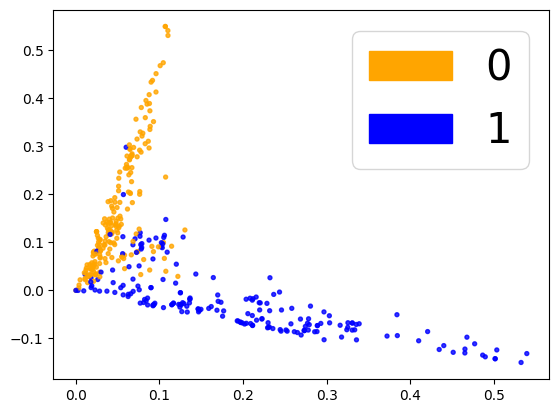

In [111]:
# LSA-analysis of texts
plot_lsa(X_train, y_train)
plt.show()

In [112]:
# logreg training
clf = LogisticRegressionCV(solver='newton-cg', multi_class='ovr', n_jobs=-1, random_state=0)
clf = train_model(clf, X_train, y_train)
y_pred = clf.predict(X_test)

In [113]:
# metrics output
accuracy, precision, recall, f1, roc_auc = show_metrics(y_test, y_pred)
print(f"accuracy = {accuracy},\nprecision = {precision},\nrecall = {recall},\nf1 = {f1},\nroc_auc = {roc_auc}.\n", end='\n') 
cr = classification_report(y_test, y_pred)
print('Classification report:\n\n', cr, end='\n')

accuracy = 0.8811881188118812,
precision = 0.8973360655737705,
recall = 0.8801960784313725,
f1 = 0.8797619047619047,
roc_auc = 0.8801960784313726.

Classification report:

               precision    recall  f1-score   support

           0       0.82      0.98      0.89        51
           1       0.97      0.78      0.87        50

    accuracy                           0.88       101
   macro avg       0.90      0.88      0.88       101
weighted avg       0.90      0.88      0.88       101



In [114]:
# training classifier on the whole data
clf = train_model(clf, X, y)

In [115]:
# cross-validation
cv = cross_val_score(clf, X, y, scoring='roc_auc', cv=10)
print('Cross-validation: ', cv)

Cross-validation:  [0.68      0.7900641 1.        1.        1.        0.9984    1.
 1.        1.        0.9344   ]


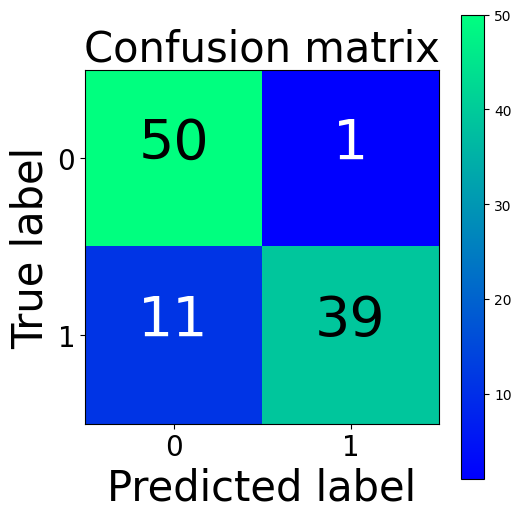

In [116]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(5, 5))
plot = plot_confusion_matrix(cm, classes=['0', '1'], normalize=False, title='Confusion matrix')
plt.show()

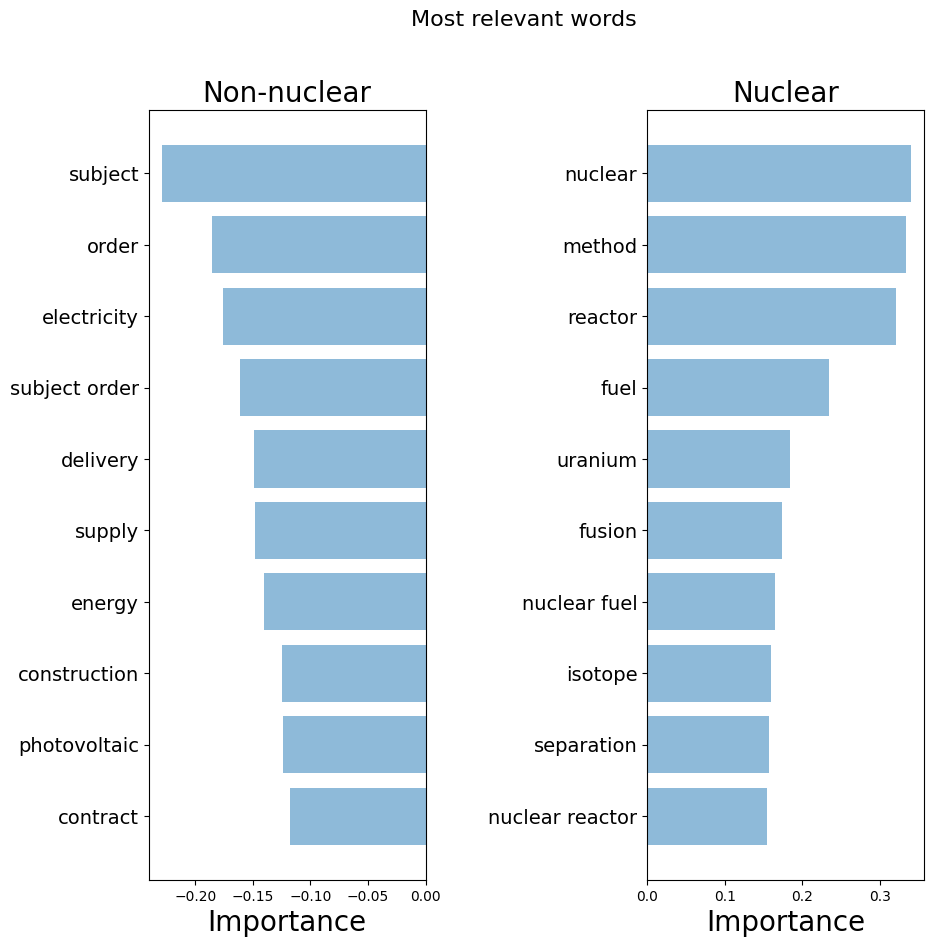

In [117]:
# word importance
importance = get_most_important_features(tfidf, clf, 10)

# BERT fine-tuning and evaluation

In [150]:
# text processing for BERT
train_dataloader, validation_dataloader = bert_preprocessing(df['Translated text'], y, val_ratio=0.2, batch_size=16)

In [151]:
# initialising pre-trained BERT

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
try:
    model.cuda()
except AssertionError:
    pass

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [152]:
# BERT fine-tuning
model = bert_train(model, train_dataloader, epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


	 - Train loss: 0.7195

	 - Train loss: 0.6712

	 - Train loss: 0.6483

	 - Train loss: 0.6289

	 - Train loss: 0.6423

	 - Train loss: 0.6210

	 - Train loss: 0.6102

	 - Train loss: 0.5909

	 - Train loss: 0.5696

	 - Train loss: 0.5704

	 - Train loss: 0.5578

	 - Train loss: 0.5435

	 - Train loss: 0.5226

	 - Train loss: 0.4992

	 - Train loss: 0.4822

	 - Train loss: 0.4705

	 - Train loss: 0.4615

	 - Train loss: 0.4523

	 - Train loss: 0.4461

	 - Train loss: 0.4368

	 - Train loss: 0.4285

	 - Train loss: 0.4210

	 - Train loss: 0.4193

	 - Train loss: 0.4132


Epoch:   0%|          | 0/10 [00:01<?, ?it/s]


	 - Train loss: 0.4235


In [153]:
# pre-trained model evaluation
bert_eval(model, validation_dataloader)

	 - Validation Accuracy: 0.9375
	 - Validation Precision: 0.9326530612244898
	 - Validation Recall: 0.9532967032967034
	 - Validation f1: 0.9326530612244898
	 - Validation ROC-AUC: 0.9532967032967034


BERT results are significantly better than logreg, but inference is longer. The results may be enhanced if the dataset is broadened. For now, I'll use logreg in prod as it while the program is being tested.

In [122]:
# saving model to pikle file
with open("logreg_model.pkl", 'wb') as file:
    pickle.dump((clf, tfidf), file)

In [ ]:
# prediction
#df = pd.read_excel('test_dataset.xlsx')
#prediction(df, clf, tfidf)